# Deep Image Prior (DIP) for PAM - Batch Mode Only
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from build_unet import *
from utils import *
from keras.optimizers import Adam
import os
from os.path import isfile, join
from numba import cuda
import cv2
from scipy.stats import ttest_ind, ttest_ind_from_stats
import statsmodels.stats.multicomp as mc

Using TensorFlow backend.


In [2]:
""" Choose which gpu to run the training """
gpu = 1  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Mode Selection

In [3]:
LOG_READ = False  # Read log 
SSIM_EVAL = True

### Read log

In [4]:
if LOG_READ:
    imgpath = './Data/10_5/output/'
    imgname = '20190423_thinnedskull_Epi 11_Image1_index0_pad_5-10'
    im = cv2.imread(imgpath + imgname + '_dip_out.png')
    l = np.loadtxt(imgpath + imgname + '_loss.txt')

    plt.plot(l)
    plt.yscale('log')
    plt.show()

### Evaluate SSIM

In [5]:
imgroot = './Data'
pattern = ['4_1', '5_1', '6_1', '7_3', '10_5']
pattern_n = ['[4,1]', '[5,1]', '[6,1]', '[7,3]', '[10,5]']
metrics = ['SSIM', 'PSNR']
method = ['Bilinear', 'Bicubic', 'Lanczos', 'DIP-PAM', 'FD U-Net']
batch = 37

imgpath = imgroot + '/' + pattern[0]
list_dir = os.listdir(imgpath)
list_file = [f for f in list_dir if isfile(join(imgpath, f))]
prefix, suffix = list_file[0].split('.')
print(suffix)

png


In [6]:
count_p = 1
s_dip = np.zeros((len(pattern), batch))
s_bilinear = np.zeros((len(pattern), batch))
s_bicubic = np.zeros((len(pattern), batch))
s_lanczos = np.zeros((len(pattern), batch))
s_dl = np.zeros((len(pattern), batch))
p_dip = np.zeros((len(pattern), batch))
p_bilinear = np.zeros((len(pattern), batch))
p_lanczos = np.zeros((len(pattern), batch))
p_bicubic = np.zeros((len(pattern), batch))
p_dl = np.zeros((len(pattern), batch))
dip = np.zeros((300, 300, len(pattern), batch))
bicubic = np.copy(dip)
bilinear = np.copy(dip)
lanczos = np.copy(dip)
gt = np.copy(dip)
dl = np.copy(dip)

for p in pattern:
    count_f = 1
    imgpath = imgroot + '/' + p
    list_dir = os.listdir(imgpath)
    list_file = [f for f in list_dir if isfile(join(imgpath, f))]
    for f in list_file:        
#         print('Current count: ' + str(count_f))
#         print(f)
        
        imgname, imgsuffix = f.split('.')
        if imgsuffix != 'png':
            continue

        im = cv2.imread(imgpath + '/' + f)
        im2 = cv2.imread(imgpath + '/deep_learning/' + imgname + '.' + imgsuffix)
        im2 = im2[:, :, 0]
        im2 = cv2.resize(im2, (im.shape[1], im.shape[0]),
                            interpolation=cv2.INTER_CUBIC)
        im = im[round(im.shape[0]/2)-150:round(im.shape[0]/2)+150,round(im.shape[1]/2)-150:round(im.shape[1]/2)+150]
        im_ori, im_gt, im_masked, im_mask, im_bicubic, factor, im_bilinear, im_lanczos = readImg(im)

        im2 = im2[round(im2.shape[0]/2)-150:round(im2.shape[0]/2)+150,round(im2.shape[1]/2)-150:round(im2.shape[1]/2)+150]
        im_dl = np.copy(im2)
        im2 = cv2.imread(imgpath + '/output/' + imgname + '_dip_out.' + imgsuffix)
        if im2 is None:
            continue
        im_dip = im2[:, :, 1]
        
        # Save ssim values
        s_dip[count_p-1, count_f-1] = ssim(im_dip, im_gt, data_range=255)
        s_bicubic[count_p-1, count_f-1] = ssim(im_bicubic, im_gt, data_range=255)
        s_dl[count_p-1, count_f-1] = ssim(im_dl, im_gt, data_range=255)
        s_bilinear[count_p-1, count_f-1] = ssim(im_bilinear, im_gt, data_range=255)
        s_lanczos[count_p-1, count_f-1] = ssim(im_lanczos, im_gt, data_range=255)
        
        # Save psnr values
        p_dip[count_p-1, count_f-1] = psnr(im_dip, im_gt)
        p_bicubic[count_p-1, count_f-1] = psnr(im_bicubic, im_gt)
        p_dl[count_p-1, count_f-1] = psnr(im_dl, im_gt)
        p_bilinear[count_p-1, count_f-1] = psnr(im_bilinear, im_gt)
        p_lanczos[count_p-1, count_f-1] = psnr(im_lanczos, im_gt)
        
        # Save images
        dip[:, :, count_p-1, count_f-1] = im_dip
        bicubic[:, :, count_p-1, count_f-1] = im_bicubic
        dl[:, :, count_p-1, count_f-1] = im_dl
        bilinear[:, :, count_p-1, count_f-1] = im_bilinear
        lanczos[:, :, count_p-1, count_f-1] = im_lanczos
        gt[:, :, count_p-1, count_f-1] = im_gt

        count_f += 1
        if count_f > batch:
            break
    
    count_p += 1

In [7]:
# Multiple Student t-test
def get_pval(d1, d2, n1, n2, idx, eol=False):
    t, p = ttest_ind(d1[idx, :], d2[idx, :], equal_var=False)
    if eol:
        print(pattern[idx], n1, n2, p, '\n')
    else:
        print(pattern[idx], n1, n2, p)
    return t, p
    
# Get p-value 
print('SSIM:')

for idx in range(-1, -len(pattern)-1, -1):
    get_pval(s_bicubic, s_dip, 'bicubic', 'dip', idx)
    if idx == -len(pattern):
        get_pval(s_dl, s_dip, 'dl', 'dip', idx)
        get_pval(s_dl, s_bicubic, 'dl', 'bicubic', idx, eol=True)
    else:
        get_pval(s_dl, s_dip, 'dl', 'dip', idx, eol=True)
        
print('PSNR:')

for idx in range(-1, -len(pattern)-1, -1):
    get_pval(p_bicubic, p_dip, 'bicubic', 'dip', idx)
    if idx == -len(pattern):
        get_pval(p_dl, p_dip, 'dl', 'dip', idx)
        get_pval(p_dl, p_bicubic, 'dl', 'bicubic', idx, eol=True)
    else:
        get_pval(p_dl, p_dip, 'dl', 'dip', idx, eol=True)

SSIM:
10_5 bicubic dip 2.604895205953353e-08
10_5 dl dip 0.011358237677990908 

7_3 bicubic dip 0.0010667226629125256
7_3 dl dip 0.03135801978650476 

6_1 bicubic dip 8.65852292264822e-06
6_1 dl dip 0.4488491695614951 

5_1 bicubic dip 1.151945844529469e-06
5_1 dl dip 0.02863130256290048 

4_1 bicubic dip 0.018213851257749703
4_1 dl dip 0.00022218857262198063
4_1 dl bicubic 0.011199922463731787 

PSNR:
10_5 bicubic dip 0.0005733312753477016
10_5 dl dip 0.2837961775125476 

7_3 bicubic dip 0.03604120296057198
7_3 dl dip 0.3967307210925596 

6_1 bicubic dip 0.0005113735902805059
6_1 dl dip 0.774750149757343 

5_1 bicubic dip 4.574987981619713e-05
5_1 dl dip 0.5306441161204745 

4_1 bicubic dip 0.6116135431365235
4_1 dl dip 0.13097982640034886
4_1 dl bicubic 0.23973868350266808 



In [8]:
# SSIM
s_stack = np.dstack((s_bilinear, s_bicubic, s_lanczos, s_dip, s_dl))
p_stack = np.dstack((p_bilinear, p_bicubic, p_lanczos, p_dip, p_dl))
s_label = ["           " for x in range(np.prod(s_stack.shape))]
s_label = np.reshape(s_label, (s_stack.shape))
print(s_label.dtype)
for i in range(s_stack.shape[-1]):
    s_label[:, :, i] = method[i]
    print(pattern[i])

# Get only bicubic, DIP and FDUNet
p_stack = np.dstack((p_stack[:, :, 1], p_stack[:, :, -2], p_stack[:, :, -1]))
s_stack = np.dstack((s_stack[:, :, 1], s_stack[:, :, -2], s_stack[:, :, -1]))
s_label = np.dstack((s_label[:, :, 1], s_label[:, :, -2], s_label[:, :, -1]))

<U11
4_1
5_1
6_1
7_3
10_5


In [9]:
# ANOVA with post-hoc Tukey - folllow the example in https://www.pythonfordatascience.org/anova-python/
# A good post on post-hoc tests with ANOVA: https://statisticsbyjim.com/anova/post-hoc-tests-anova/
idx = -1
print(pattern[idx])
comp = mc.MultiComparison(p_stack[idx, :, :].flatten(), s_label[idx, :, :].flatten())
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

10_5


group1,group2,meandiff,p-adj,lower,upper,reject
Bicubic,DIP-PAM,2.9836,0.0024,0.9189,5.0484,True
Bicubic,FD U-Net,3.9929,0.001,1.9282,6.0577,True
DIP-PAM,FD U-Net,1.0093,0.4802,-1.0555,3.0741,False


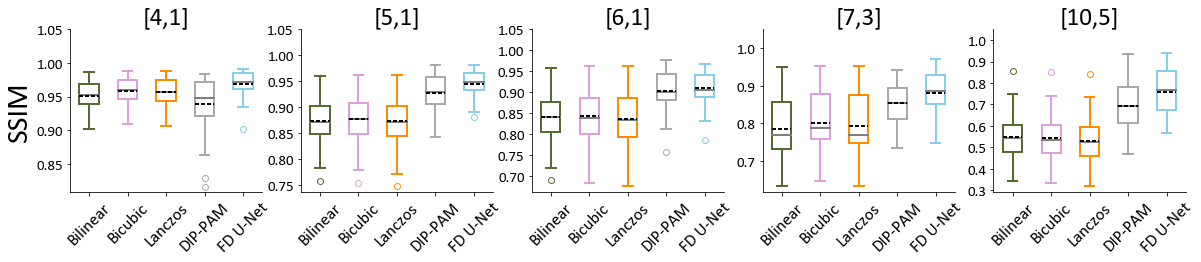

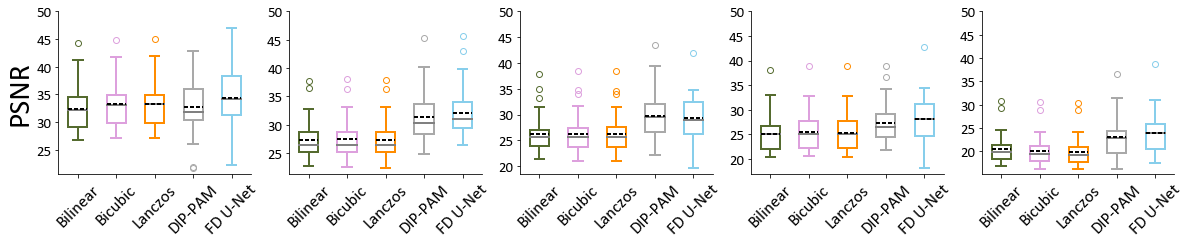

In [10]:
# Print subplots
method_c = ['darkolivegreen', 'plum', 'darkorange', 'darkgray', 'skyblue']
lw = 2
meanpointprops = dict(linewidth=lw, color='k', linestyle='-')
medianpointprops = dict(linewidth=lw, color='gray')
boxprops = dict(linewidth=lw)
flineprops = dict(linewidth=lw)
fname = 'Calibri'
for j in range(len(metrics)):
    fig = plt.figure(figsize=(20,3))
    for i in range(len(pattern)):
        ax = fig.add_subplot(1, len(pattern), i+1)
        if j == 0:
            ax.set_title(pattern_n[i], fontsize=25, fontname=fname)
            bp = plt.boxplot([s_bilinear[i, :], s_bicubic[i, :], s_lanczos[i, :], s_dip[i, :], s_dl[i, :]], 
                        boxprops=boxprops, medianprops=medianpointprops, whiskerprops=flineprops, capprops=flineprops,
                       showmeans=True, meanline=True, meanprops=meanpointprops, patch_artist=True)
            plt.ylim(top=1.05)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            for patch, flier, mean, color in zip(bp['boxes'], bp['fliers'], bp['means'], method_c):
                flier.set(markeredgecolor=color)
                mean.set_linestyle('--')
                mean.set_dashes((2, 1, 2, 1))
                patch.set_edgecolor(color)
                patch.set_facecolor('white')
            count = 0
            for wker, cap in zip(bp['whiskers'], bp['caps']):
                wker.set(color=method_c[count//2])
                cap.set(color=method_c[count//2])
                count += 1
        if j == 1:
            bp = plt.boxplot([p_bilinear[i, :], p_bicubic[i, :], p_lanczos[i, :], p_dip[i, :], p_dl[i, :]], 
                        boxprops=boxprops, medianprops=medianpointprops, whiskerprops=flineprops, capprops=flineprops,
                       showmeans=True, meanline=True, meanprops=meanpointprops, patch_artist=True)
            plt.ylim(top=50)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            for patch, flier, mean, color in zip(bp['boxes'], bp['fliers'], bp['means'], method_c):
                flier.set(markeredgecolor=color)
                mean.set_linestyle('--')
                mean.set_dashes((2, 1, 2, 1))
                patch.set_edgecolor(color)
                patch.set_facecolor('white')
            count = 0
            for wker, cap in zip(bp['whiskers'], bp['caps']):
                wker.set(color=method_c[count//2])
                cap.set(color=method_c[count//2])
                count += 1
        if i == 0:
            plt.ylabel(metrics[j], fontsize=30, fontname=fname)
        plt.xticks([1, 2, 3, 4, 5], method, 
                   fontsize=17, fontname=fname)
        plt.xticks(rotation=45)
        plt.yticks(fontsize=15, fontname=fname)
    
    plt.show()

In [11]:
# Calculate mean SSIM
s_dip_mean = np.mean(s_dip, axis=1)
s_bicubic_mean = np.mean(s_bicubic, axis=1)
s_dl_mean = np.mean(s_dl, axis=1)
s_bilinear_mean = np.mean(s_bilinear, axis=1)
s_lanczos_mean = np.mean(s_lanczos, axis=1)
s_mean = np.flipud(np.squeeze(np.dstack((s_bilinear_mean, s_bicubic_mean, s_lanczos_mean,
                               s_dip_mean, s_dl_mean))))

# Calculate mean PSNR
p_dip_mean = np.mean(p_dip, axis=1)
p_bicubic_mean = np.mean(p_bicubic, axis=1)
p_dl_mean = np.mean(p_dl, axis=1)
p_bilinear_mean = np.mean(p_bilinear, axis=1)
p_lanczos_mean = np.mean(p_lanczos, axis=1)
p_mean = np.flipud(np.squeeze(np.dstack((p_bilinear_mean, p_bicubic_mean, p_lanczos_mean,
                               p_dip_mean, p_dl_mean))))

In [12]:
p_mean

array([[20.45906139, 20.05741286, 19.91470796, 23.04103659, 24.05034868],
       [25.16787065, 25.41521395, 25.37565939, 27.34790757, 28.1714873 ],
       [26.2707758 , 26.30788838, 26.23310829, 29.70847702, 29.42646572],
       [27.37631627, 27.4369044 , 27.38540489, 31.4205508 , 32.05855816],
       [32.41225366, 33.19128976, 33.2482535 , 32.66692267, 34.375366  ]])

In [13]:
# Calculate standard dev SSIM
s_dip_std = np.std(s_dip, axis=1)
s_bicubic_std = np.std(s_bicubic, axis=1)
s_dl_std = np.std(s_dl, axis=1)
s_bilinear_std = np.std(s_bilinear, axis=1)
s_lanczos_std = np.std(s_lanczos, axis=1)
s_std = np.flipud(np.squeeze(np.dstack((s_bilinear_std, s_bicubic_std, s_lanczos_std,
                                        s_dip_std, s_dl_std))))

# Calculate standard dev PSNR
p_dip_std = np.std(p_dip, axis=1)
p_bicubic_std = np.std(p_bicubic, axis=1)
p_dl_std = np.std(p_dl, axis=1)
p_bilinear_std = np.std(p_bilinear, axis=1)
p_lanczos_std = np.std(p_lanczos, axis=1)
p_std = np.flipud(np.squeeze(np.dstack((p_bilinear_std, p_bicubic_std, p_lanczos_std,
                                        p_dip_std, p_dl_std))))

In [14]:
p_std

array([[3.03343833, 3.05137707, 3.06686155, 3.90230751, 4.02737321],
       [3.6699132 , 3.87968922, 3.9334493 , 3.79576837, 4.37929333],
       [3.50831076, 3.66660637, 3.68803705, 4.23447296, 4.09501388],
       [3.33948358, 3.41838783, 3.43421339, 4.29571933, 4.29647164],
       [3.69808434, 3.80195073, 3.84024257, 4.85626601, 4.63025945]])

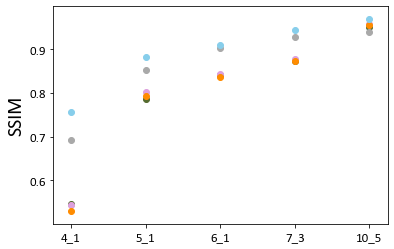

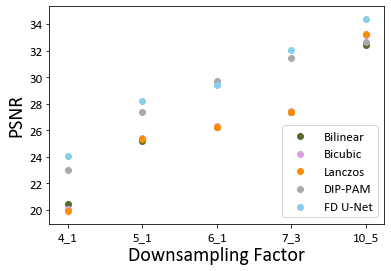

In [15]:
fsize = 13
for i in range(s_mean.shape[1]):
#     plt.errorbar(np.arange(0, s_mean.shape[0]), s_mean[:,i],
#                 yerr=s_std[:,i], fmt='o', label=method[i], 
#                  capsize=5, mfc=method_c[i], mec=method_c[i],
#                 ecolor=method_c[i])
    plt.scatter(np.arange(0, s_mean.shape[0]), s_mean[:,i], 
                label=method[i], facecolor=method_c[i])
plt.ylabel('SSIM', fontsize=20, fontname=fname)
plt.yticks(fontsize=fsize, fontname=fname)
plt.xticks([0, 1, 2, 3, 4], pattern, fontsize=fsize, fontname=fname)
# plt.legend()
plt.show()

for i in range(p_mean.shape[1]):
#     plt.errorbar(np.arange(0, p_mean.shape[0]), p_mean[:,i],
#                 yerr=p_std[:,i], fmt='o', label=method[i], 
#                  capsize=5, mfc=method_c[i], mec=method_c[i],
#                 ecolor=method_c[i])
    plt.scatter(np.arange(0, s_mean.shape[0]), p_mean[:,i], 
                label=method[i], facecolor=method_c[i])
plt.ylabel('PSNR', fontsize=20, fontname=fname)
plt.xlabel('Downsampling Factor', fontsize=20, fontname=fname)
plt.yticks(fontsize=fsize, fontname=fname)
plt.xticks([0, 1, 2, 3, 4], pattern, fontsize=fsize, fontname=fname)
plt.rc('legend',fontsize=fsize) 
plt.rc('font',family=fname) 
plt.legend()
plt.show()

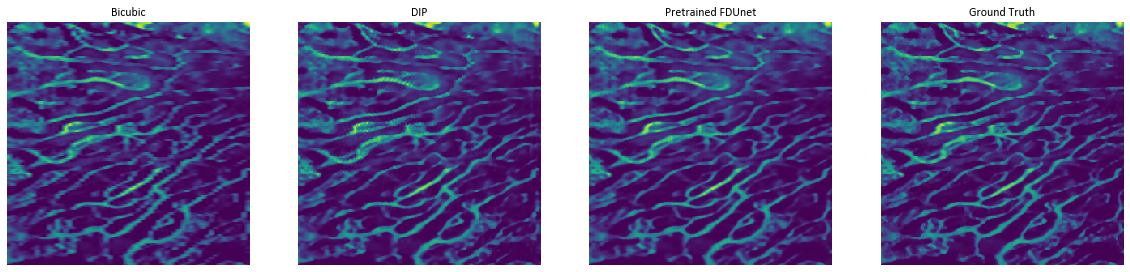

In [16]:
idx = [1, 1]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 2)
ax.set_title("DIP")
plt.imshow(dip[:, :, idx[0], idx[1]])
plt.axis('off')
ax = fig.add_subplot(1, 4, 1)
ax.set_title("Bicubic")
plt.imshow(bicubic[:, :, idx[0], idx[1]])
plt.axis('off')
ax = fig.add_subplot(1, 4, 3)
ax.set_title("Pretrained FDUnet")
plt.imshow(dl[:, :, idx[0], idx[1]])
plt.axis('off')
ax = fig.add_subplot(1, 4, 4)
ax.set_title("Ground Truth")
plt.imshow(gt[:, :, idx[0], idx[1]])
plt.axis('off')
plt.show()

In [17]:
idx = [-5, 19]
print(pattern[idx[0]])
print(s_bilinear[idx[0], idx[1]])
print(s_bicubic[idx[0], idx[1]])
print(s_lanczos[idx[0], idx[1]])
print(s_dip[idx[0], idx[1]])
print(s_dl[idx[0], idx[1]])

4_1
0.9613217122734063
0.9675361135679398
0.9673063492482933
0.971491071943047
0.9506882727924691


In [18]:
print(pattern[idx[0]])
print(p_bilinear[idx[0], idx[1]])
print(p_bicubic[idx[0], idx[1]])
print(p_lanczos[idx[0], idx[1]])
print(p_dip[idx[0], idx[1]])
print(p_dl[idx[0], idx[1]])

4_1
33.06875334271846
33.885616949908616
33.935681237094386
36.17524776439359
26.25198692692416


### Process phantom data

In [19]:
fpath = './Data/phantom_img_results/phantom_output_imgs_'
pattern_pt = ['4-1', '5-1', '6-1', '7-3', '10-5']
wl = [532, 590]
s_dip = np.zeros((len(pattern_pt), len(wl)))
s_bilinear = np.zeros((len(pattern_pt), len(wl)))
s_bicubic = np.zeros((len(pattern_pt), len(wl)))
s_lanczos = np.zeros((len(pattern_pt), len(wl)))
s_dl = np.zeros((len(pattern_pt), len(wl)))
p_dip = np.zeros((len(pattern_pt), len(wl)))
p_bilinear = np.zeros((len(pattern_pt), len(wl)))
p_lanczos = np.zeros((len(pattern_pt), len(wl)))
p_bicubic = np.zeros((len(pattern_pt), len(wl)))
p_dl = np.zeros((len(pattern_pt), len(wl)))
dip = np.zeros((1042, 750, len(pattern_pt), len(wl)))
bicubic = np.copy(dip)
bilinear = np.copy(dip)
lanczos = np.copy(dip)
gt = np.copy(dip)
dl = np.copy(dip)

count_p =  1
for i in pattern_pt:
    count_f = 1
    for j in wl:
        duke_ori = cv2.imread(fpath + i + '/Duke_' + str(j) + '.png')
        duke_dip = cv2.imread(fpath + i + '/Duke_' + str(j) + '_dip_out.png')

        im_gt = duke_ori[:, :, -1]
        im_dip = duke_dip[:duke_ori.shape[0], :duke_ori.shape[1], 1]
        im_mask = duke_dip[:duke_ori.shape[0], :duke_ori.shape[1], 0]
        im_masked = im_gt*(im_mask/255)

        im_down = im_masked[im_mask!=0]
        [x_down, y_down] = np.where(im_mask!=0)
        x_down = np.unique(x_down)
        y_down = np.unique(y_down)
        #     print(x_down, y_down)
        im_down = im_down.reshape(len(x_down), len(y_down))
        im_bicubic = cv2.resize(im_down, (im_gt.shape[1], im_gt.shape[0]),
                            interpolation=cv2.INTER_CUBIC)
        im_bilinear = cv2.resize(im_down, (im_gt.shape[1], im_gt.shape[0]),
                            interpolation=cv2.INTER_LINEAR)
        im_lanczos = cv2.resize(im_down, (im_gt.shape[1], im_gt.shape[0]),
                            interpolation=cv2.INTER_LANCZOS4)

        duke_dl = cv2.imread(fpath + i + '/deep_learning/Duke_' + str(j) + '.png')
        im_dl = duke_dl[:duke_ori.shape[0], :duke_ori.shape[1], 0]
        
        # Save ssim values
        s_dip[count_p-1, count_f-1] = ssim(im_dip, im_gt, data_range=255)
        s_bicubic[count_p-1, count_f-1] = ssim(im_bicubic, im_gt, data_range=255)
        s_dl[count_p-1, count_f-1] = ssim(im_dl, im_gt, data_range=255)
        s_bilinear[count_p-1, count_f-1] = ssim(im_bilinear, im_gt, data_range=255)
        s_lanczos[count_p-1, count_f-1] = ssim(im_lanczos, im_gt, data_range=255)
        
        # Save psnr values
        p_dip[count_p-1, count_f-1] = psnr(im_gt, im_dip)
        p_bicubic[count_p-1, count_f-1] = psnr(im_gt, im_bicubic)
        p_dl[count_p-1, count_f-1] = psnr(im_gt, im_dl)
        p_bilinear[count_p-1, count_f-1] = psnr(im_gt, im_bilinear)
        p_lanczos[count_p-1, count_f-1] = psnr(im_gt, im_lanczos)
        
#         # Save images
#         dip[:, :, count_p-1, count_f-1] = im_dip
#         bicubic[:, :, count_p-1, count_f-1] = im_bicubic
#         dl[:, :, count_p-1, count_f-1] = im_dl
#         bilinear[:, :, count_p-1, count_f-1] = im_bilinear
#         lanczos[:, :, count_p-1, count_f-1] = im_lanczos
#         gt[:, :, count_p-1, count_f-1] = im_gt

        count_f += 1
        if count_f > batch:
            break
    
    count_p += 1



C:\Users\PI-Lab\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\measure\simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [20]:
print(np.mean(s_bilinear, axis=1))
print(np.mean(s_bicubic, axis=1))
print(np.mean(s_lanczos, axis=1))
print(np.mean(s_dip, axis=1))
print(np.mean(s_dl, axis=1))

[0.93508335 0.84321534 0.77914146 0.67820804 0.55598421]
[0.93755369 0.8352164  0.76460255 0.65953486 0.51618528]
[0.93757886 0.83101053 0.75756524 0.64752103 0.50032213]
[0.76176485 0.74542011 0.77471845 0.66251817 0.59557283]
[0.90979331 0.85866202 0.8499466  0.69901255 0.64012536]


In [21]:
print(np.mean(p_bilinear, axis=1))
print(np.mean(p_bicubic, axis=1))
print(np.mean(p_lanczos, axis=1))
print(np.mean(p_dip, axis=1))
print(np.mean(p_dl, axis=1))

[30.68374895 25.62685429 23.58110098 22.95126821 19.49275439]
[30.98248776 25.43510735 23.28039641 22.65584777 19.06499833]
[31.01389029 25.34749837 23.1838863  22.5019549  18.92660913]
[26.04823776 25.50736853 25.41349717 23.59659508 22.38712589]
[24.73412695 27.9837813  28.02543979 25.19806383 22.93119185]
